# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:26<00:00, 2.31KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

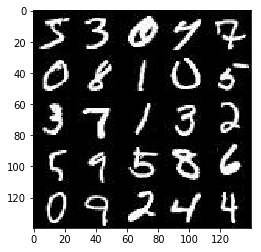

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

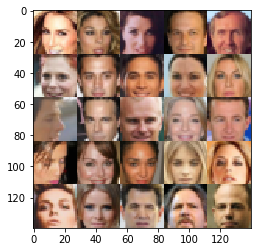

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


/Users/amir.ziai/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/Users/amir.ziai/anaconda/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/Users/amir.ziai/anaconda/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/Users/amir.ziai/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/Users/amir.ziai/anaconda/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/Users/amir.ziai/anaconda/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/Users/amir.ziai/anaconda/lib/python3.5/site-packa

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer 1
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="SAME",
                              kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        lrelu1 = tf.maximum(alpha * h1, h1)
        
        
        # Hidden Layer 2
        h2 = tf.layers.conv2d(lrelu1, 128, 5, strides=1, padding="SAME",
                              kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(h2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        
        
        # Hidden Layer 3
        h3 = tf.layers.conv2d(lrelu2, 256, 5, strides=2, padding="SAME", 
                             kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        bn3 = tf.layers.batch_normalization(h3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        
        #Flatten
        flat = tf.reshape(lrelu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # Ffully connected layer
        h1 = tf.layers.dense(z, 7*7*256)
        
        # Reshape 
        h1 = tf.reshape(h1, (-1, 7, 7, 256))
        bn1 = tf.layers.batch_normalization(h1, training=is_train)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        
        
        # Hidden Layer 2
        h2 = tf.layers.conv2d_transpose(lrelu1, 128, 5, strides=1, padding="SAME")
        bn2 = tf.layers.batch_normalization(h2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
       
        
        # Hidden Layer 3
        h3 = tf.layers.conv2d_transpose(lrelu2, 64, 5, strides=2, padding='SAME')
        bn3 = tf.layers.batch_normalization(h3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
       
        
        # Output layer, 28x28x5
        logits = tf.layers.conv2d_transpose(lrelu3, out_channel_dim, 5, strides=2, padding="SAME")
        
        out = tf.tanh(logits)
       
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    # Generator  
    g_model = generator(input_z, out_channel_dim, is_train=True)

    # Disriminator 
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # Calculate loss
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
     labels=tf.ones_like(d_logits_real) * (1 - smooth)))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
     labels=tf.zeros_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    # Set the image dimensions
    _, image_width, image_height, image_channels = data_shape
    
    # Implement model_inputs to set the input_real, input_z, and learning rate
    input_real, input_z, _learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Implement model_loss to set the d_loss and g_loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # Implement model_opt to set d_train_opt and g_train_opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Batch counter
    batch_count = 0
    
    # Number of images to print
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # Multiply batch_images by 2.0 since the dataset ranges from -0.5 to 0.5
                batch_images = batch_images*2.0
                
                # Random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                # Increment the batch count
                batch_count += 1

                # Print the d_train_loss and g_train_loss every 10 batches
                if (batch_count % 10 == 0):
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))   
                    
                # Print the generator output every 100 batches
                if (batch_count % 100 == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8492... Generator Loss: 1.5182
Epoch 1/2... Discriminator Loss: 1.5124... Generator Loss: 4.5619
Epoch 1/2... Discriminator Loss: 0.9467... Generator Loss: 1.3255
Epoch 1/2... Discriminator Loss: 2.1573... Generator Loss: 0.2348
Epoch 1/2... Discriminator Loss: 1.1456... Generator Loss: 0.8638
Epoch 1/2... Discriminator Loss: 0.6808... Generator Loss: 2.0060
Epoch 1/2... Discriminator Loss: 1.1837... Generator Loss: 2.8617
Epoch 1/2... Discriminator Loss: 0.7088... Generator Loss: 2.6927
Epoch 1/2... Discriminator Loss: 0.6471... Generator Loss: 1.6375
Epoch 1/2... Discriminator Loss: 0.5810... Generator Loss: 2.1056


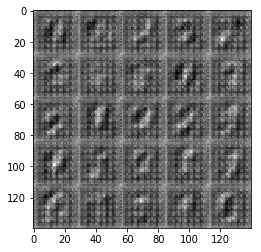

Epoch 1/2... Discriminator Loss: 0.7720... Generator Loss: 1.7313
Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 3.3488
Epoch 1/2... Discriminator Loss: 1.2619... Generator Loss: 0.6364
Epoch 1/2... Discriminator Loss: 1.4136... Generator Loss: 3.6923
Epoch 1/2... Discriminator Loss: 1.1246... Generator Loss: 0.8220
Epoch 1/2... Discriminator Loss: 1.4174... Generator Loss: 0.5094
Epoch 1/2... Discriminator Loss: 0.7384... Generator Loss: 2.5613
Epoch 1/2... Discriminator Loss: 0.7684... Generator Loss: 1.9379
Epoch 1/2... Discriminator Loss: 0.7591... Generator Loss: 1.2430
Epoch 1/2... Discriminator Loss: 0.9772... Generator Loss: 3.1786


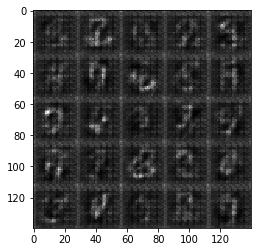

Epoch 1/2... Discriminator Loss: 0.6837... Generator Loss: 2.1897
Epoch 1/2... Discriminator Loss: 0.8039... Generator Loss: 1.5140
Epoch 1/2... Discriminator Loss: 1.1593... Generator Loss: 0.6610
Epoch 1/2... Discriminator Loss: 0.8198... Generator Loss: 1.1513
Epoch 1/2... Discriminator Loss: 0.6677... Generator Loss: 2.3776
Epoch 1/2... Discriminator Loss: 0.7108... Generator Loss: 1.3838
Epoch 1/2... Discriminator Loss: 0.6851... Generator Loss: 1.5629
Epoch 1/2... Discriminator Loss: 0.7865... Generator Loss: 1.5632
Epoch 1/2... Discriminator Loss: 0.6974... Generator Loss: 1.7880
Epoch 1/2... Discriminator Loss: 0.6493... Generator Loss: 2.2465


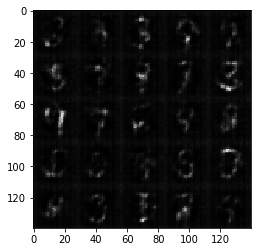

Epoch 1/2... Discriminator Loss: 1.0611... Generator Loss: 3.4997
Epoch 1/2... Discriminator Loss: 1.0873... Generator Loss: 0.7519
Epoch 1/2... Discriminator Loss: 0.6487... Generator Loss: 1.8693
Epoch 1/2... Discriminator Loss: 0.6533... Generator Loss: 1.5964
Epoch 1/2... Discriminator Loss: 0.5492... Generator Loss: 2.2056
Epoch 1/2... Discriminator Loss: 0.5899... Generator Loss: 1.9001
Epoch 1/2... Discriminator Loss: 0.6393... Generator Loss: 1.5707
Epoch 1/2... Discriminator Loss: 0.6479... Generator Loss: 1.6223
Epoch 1/2... Discriminator Loss: 0.6496... Generator Loss: 2.0258
Epoch 1/2... Discriminator Loss: 0.8459... Generator Loss: 1.0952


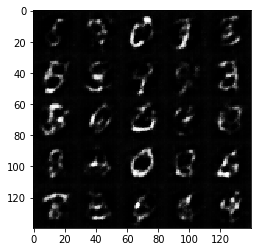

Epoch 1/2... Discriminator Loss: 0.6684... Generator Loss: 2.0289
Epoch 1/2... Discriminator Loss: 0.6847... Generator Loss: 1.5595
Epoch 1/2... Discriminator Loss: 0.6712... Generator Loss: 2.4222
Epoch 1/2... Discriminator Loss: 0.6690... Generator Loss: 1.4186
Epoch 1/2... Discriminator Loss: 0.5479... Generator Loss: 2.0646
Epoch 1/2... Discriminator Loss: 0.7198... Generator Loss: 2.9273
Epoch 1/2... Discriminator Loss: 1.5421... Generator Loss: 1.6487
Epoch 1/2... Discriminator Loss: 0.6397... Generator Loss: 1.7084
Epoch 1/2... Discriminator Loss: 0.8723... Generator Loss: 1.7586
Epoch 1/2... Discriminator Loss: 0.7547... Generator Loss: 1.3341


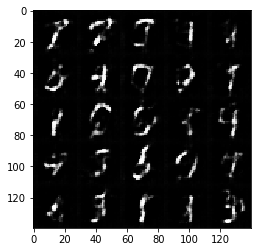

Epoch 1/2... Discriminator Loss: 1.3179... Generator Loss: 0.6208
Epoch 1/2... Discriminator Loss: 0.8506... Generator Loss: 1.1158
Epoch 1/2... Discriminator Loss: 0.6616... Generator Loss: 1.7862
Epoch 1/2... Discriminator Loss: 0.8483... Generator Loss: 1.1849
Epoch 1/2... Discriminator Loss: 0.7128... Generator Loss: 1.8857
Epoch 1/2... Discriminator Loss: 0.8439... Generator Loss: 1.0875
Epoch 1/2... Discriminator Loss: 3.0107... Generator Loss: 0.1075
Epoch 1/2... Discriminator Loss: 0.8300... Generator Loss: 1.4298
Epoch 1/2... Discriminator Loss: 0.7510... Generator Loss: 1.4032
Epoch 1/2... Discriminator Loss: 0.7840... Generator Loss: 1.6998


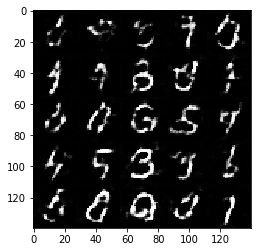

Epoch 1/2... Discriminator Loss: 0.7511... Generator Loss: 1.3509
Epoch 1/2... Discriminator Loss: 0.7138... Generator Loss: 2.1281
Epoch 1/2... Discriminator Loss: 0.7159... Generator Loss: 1.4847
Epoch 1/2... Discriminator Loss: 0.6365... Generator Loss: 1.6756
Epoch 1/2... Discriminator Loss: 1.2311... Generator Loss: 2.4949
Epoch 1/2... Discriminator Loss: 0.7775... Generator Loss: 1.5537
Epoch 1/2... Discriminator Loss: 0.7354... Generator Loss: 1.7416
Epoch 1/2... Discriminator Loss: 1.1901... Generator Loss: 0.6534
Epoch 1/2... Discriminator Loss: 0.6888... Generator Loss: 1.8178
Epoch 1/2... Discriminator Loss: 0.7141... Generator Loss: 1.3689


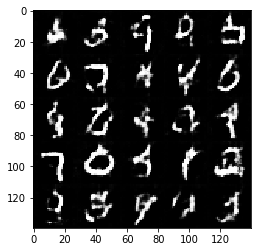

Epoch 1/2... Discriminator Loss: 0.7479... Generator Loss: 1.3111
Epoch 1/2... Discriminator Loss: 1.2778... Generator Loss: 3.5817
Epoch 1/2... Discriminator Loss: 0.7111... Generator Loss: 1.4487
Epoch 1/2... Discriminator Loss: 2.2952... Generator Loss: 4.5605
Epoch 1/2... Discriminator Loss: 0.7254... Generator Loss: 2.0453
Epoch 1/2... Discriminator Loss: 0.7213... Generator Loss: 1.3039
Epoch 1/2... Discriminator Loss: 0.8411... Generator Loss: 1.0515
Epoch 1/2... Discriminator Loss: 1.1294... Generator Loss: 0.7246
Epoch 1/2... Discriminator Loss: 1.1651... Generator Loss: 1.6888
Epoch 1/2... Discriminator Loss: 1.3588... Generator Loss: 0.6300


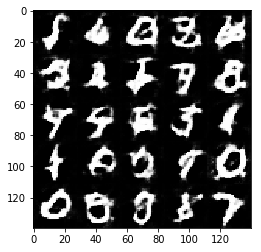

Epoch 1/2... Discriminator Loss: 0.8942... Generator Loss: 1.0768
Epoch 1/2... Discriminator Loss: 0.7781... Generator Loss: 1.3783
Epoch 1/2... Discriminator Loss: 0.6305... Generator Loss: 1.7080
Epoch 1/2... Discriminator Loss: 0.6304... Generator Loss: 2.1467
Epoch 1/2... Discriminator Loss: 0.9426... Generator Loss: 2.3243
Epoch 1/2... Discriminator Loss: 0.7781... Generator Loss: 1.4793
Epoch 1/2... Discriminator Loss: 0.9735... Generator Loss: 2.0773
Epoch 1/2... Discriminator Loss: 0.6559... Generator Loss: 1.5851
Epoch 1/2... Discriminator Loss: 0.7290... Generator Loss: 1.3624
Epoch 1/2... Discriminator Loss: 0.6831... Generator Loss: 1.4684


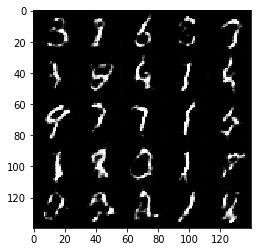

Epoch 1/2... Discriminator Loss: 0.7366... Generator Loss: 1.3327
Epoch 1/2... Discriminator Loss: 0.7491... Generator Loss: 1.2381
Epoch 1/2... Discriminator Loss: 0.7272... Generator Loss: 1.2973
Epoch 2/2... Discriminator Loss: 0.7930... Generator Loss: 1.1656
Epoch 2/2... Discriminator Loss: 1.0887... Generator Loss: 1.0130
Epoch 2/2... Discriminator Loss: 0.9543... Generator Loss: 1.7348
Epoch 2/2... Discriminator Loss: 1.2153... Generator Loss: 3.2235
Epoch 2/2... Discriminator Loss: 1.3215... Generator Loss: 0.5782
Epoch 2/2... Discriminator Loss: 0.6178... Generator Loss: 1.7101
Epoch 2/2... Discriminator Loss: 0.7614... Generator Loss: 1.3555


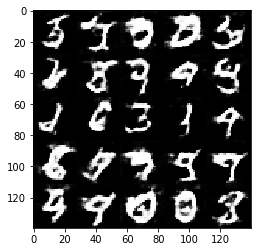

Epoch 2/2... Discriminator Loss: 1.2690... Generator Loss: 0.9013
Epoch 2/2... Discriminator Loss: 0.6899... Generator Loss: 1.5612
Epoch 2/2... Discriminator Loss: 0.6550... Generator Loss: 1.5697
Epoch 2/2... Discriminator Loss: 0.8627... Generator Loss: 1.0186
Epoch 2/2... Discriminator Loss: 0.6146... Generator Loss: 1.7172
Epoch 2/2... Discriminator Loss: 0.6425... Generator Loss: 1.5974
Epoch 2/2... Discriminator Loss: 0.7270... Generator Loss: 1.4117
Epoch 2/2... Discriminator Loss: 1.2352... Generator Loss: 0.7409
Epoch 2/2... Discriminator Loss: 0.7756... Generator Loss: 1.1701
Epoch 2/2... Discriminator Loss: 2.1256... Generator Loss: 0.2672


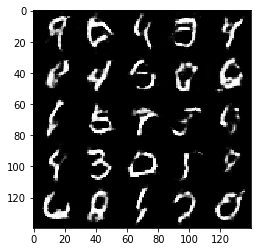

Epoch 2/2... Discriminator Loss: 0.7331... Generator Loss: 1.4245
Epoch 2/2... Discriminator Loss: 0.8486... Generator Loss: 1.1816
Epoch 2/2... Discriminator Loss: 0.5775... Generator Loss: 1.9263
Epoch 2/2... Discriminator Loss: 0.7026... Generator Loss: 1.3761
Epoch 2/2... Discriminator Loss: 1.1962... Generator Loss: 0.7328
Epoch 2/2... Discriminator Loss: 0.8532... Generator Loss: 1.1964
Epoch 2/2... Discriminator Loss: 1.1115... Generator Loss: 0.8189
Epoch 2/2... Discriminator Loss: 1.0682... Generator Loss: 0.7879
Epoch 2/2... Discriminator Loss: 1.0345... Generator Loss: 0.8185
Epoch 2/2... Discriminator Loss: 0.5930... Generator Loss: 1.7772


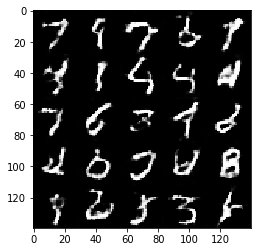

Epoch 2/2... Discriminator Loss: 1.1810... Generator Loss: 0.8628
Epoch 2/2... Discriminator Loss: 0.8962... Generator Loss: 2.7844
Epoch 2/2... Discriminator Loss: 0.9076... Generator Loss: 1.0048
Epoch 2/2... Discriminator Loss: 0.9711... Generator Loss: 0.8365
Epoch 2/2... Discriminator Loss: 0.8265... Generator Loss: 1.3704
Epoch 2/2... Discriminator Loss: 1.2411... Generator Loss: 2.1268
Epoch 2/2... Discriminator Loss: 1.0849... Generator Loss: 0.8998
Epoch 2/2... Discriminator Loss: 0.9516... Generator Loss: 0.9497
Epoch 2/2... Discriminator Loss: 1.0311... Generator Loss: 0.8632
Epoch 2/2... Discriminator Loss: 0.7659... Generator Loss: 1.2080


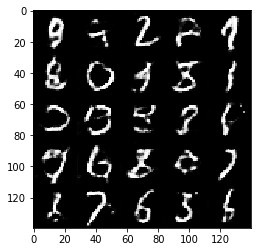

Epoch 2/2... Discriminator Loss: 0.6480... Generator Loss: 1.5248
Epoch 2/2... Discriminator Loss: 0.9907... Generator Loss: 1.8439
Epoch 2/2... Discriminator Loss: 1.9535... Generator Loss: 0.3197
Epoch 2/2... Discriminator Loss: 0.7395... Generator Loss: 1.4886
Epoch 2/2... Discriminator Loss: 0.8538... Generator Loss: 1.0629
Epoch 2/2... Discriminator Loss: 1.2051... Generator Loss: 0.6123
Epoch 2/2... Discriminator Loss: 0.7039... Generator Loss: 1.4723
Epoch 2/2... Discriminator Loss: 0.7026... Generator Loss: 1.3853
Epoch 2/2... Discriminator Loss: 0.6333... Generator Loss: 1.7834
Epoch 2/2... Discriminator Loss: 1.7017... Generator Loss: 3.7680


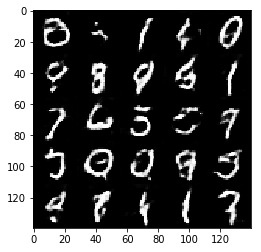

Epoch 2/2... Discriminator Loss: 0.7769... Generator Loss: 1.6964
Epoch 2/2... Discriminator Loss: 0.8323... Generator Loss: 1.3269
Epoch 2/2... Discriminator Loss: 0.8818... Generator Loss: 1.3270
Epoch 2/2... Discriminator Loss: 0.5330... Generator Loss: 2.6703
Epoch 2/2... Discriminator Loss: 1.1026... Generator Loss: 0.8217
Epoch 2/2... Discriminator Loss: 1.4420... Generator Loss: 0.5074
Epoch 2/2... Discriminator Loss: 0.9353... Generator Loss: 1.1156
Epoch 2/2... Discriminator Loss: 0.6548... Generator Loss: 1.5541
Epoch 2/2... Discriminator Loss: 0.8660... Generator Loss: 1.0693
Epoch 2/2... Discriminator Loss: 0.8826... Generator Loss: 1.3541


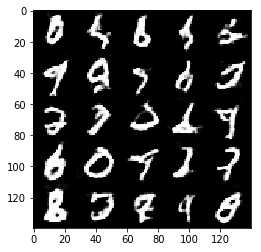

Epoch 2/2... Discriminator Loss: 0.6994... Generator Loss: 1.4929
Epoch 2/2... Discriminator Loss: 0.7570... Generator Loss: 1.4569
Epoch 2/2... Discriminator Loss: 0.5573... Generator Loss: 1.9184
Epoch 2/2... Discriminator Loss: 0.7574... Generator Loss: 1.3035
Epoch 2/2... Discriminator Loss: 0.8498... Generator Loss: 2.3447
Epoch 2/2... Discriminator Loss: 0.7481... Generator Loss: 1.5904
Epoch 2/2... Discriminator Loss: 1.3136... Generator Loss: 0.6079
Epoch 2/2... Discriminator Loss: 0.8403... Generator Loss: 1.3872
Epoch 2/2... Discriminator Loss: 1.0263... Generator Loss: 0.9215
Epoch 2/2... Discriminator Loss: 2.3338... Generator Loss: 0.2430


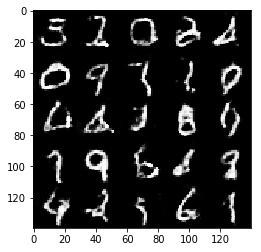

Epoch 2/2... Discriminator Loss: 0.8811... Generator Loss: 1.2527
Epoch 2/2... Discriminator Loss: 1.0471... Generator Loss: 2.0545
Epoch 2/2... Discriminator Loss: 0.6677... Generator Loss: 1.7001
Epoch 2/2... Discriminator Loss: 0.8466... Generator Loss: 1.1920
Epoch 2/2... Discriminator Loss: 0.7325... Generator Loss: 1.3044
Epoch 2/2... Discriminator Loss: 0.7459... Generator Loss: 1.7856
Epoch 2/2... Discriminator Loss: 0.7941... Generator Loss: 1.5202
Epoch 2/2... Discriminator Loss: 0.6292... Generator Loss: 2.4429
Epoch 2/2... Discriminator Loss: 1.1410... Generator Loss: 0.7371
Epoch 2/2... Discriminator Loss: 1.0634... Generator Loss: 0.7401


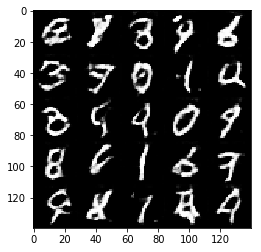

Epoch 2/2... Discriminator Loss: 0.8124... Generator Loss: 1.3133
Epoch 2/2... Discriminator Loss: 1.2588... Generator Loss: 0.5879
Epoch 2/2... Discriminator Loss: 0.7949... Generator Loss: 1.4068
Epoch 2/2... Discriminator Loss: 0.7185... Generator Loss: 1.4384
Epoch 2/2... Discriminator Loss: 0.9706... Generator Loss: 1.5313
Epoch 2/2... Discriminator Loss: 0.7369... Generator Loss: 1.4842
Epoch 2/2... Discriminator Loss: 0.7649... Generator Loss: 1.3176
Epoch 2/2... Discriminator Loss: 1.0807... Generator Loss: 0.7990
Epoch 2/2... Discriminator Loss: 0.5710... Generator Loss: 2.4441
Epoch 2/2... Discriminator Loss: 0.7336... Generator Loss: 1.4048


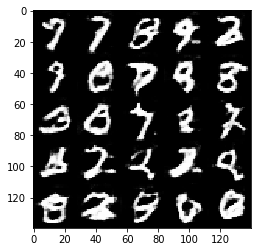

Epoch 2/2... Discriminator Loss: 0.9556... Generator Loss: 1.1868
Epoch 2/2... Discriminator Loss: 1.3433... Generator Loss: 0.5758
Epoch 2/2... Discriminator Loss: 0.8170... Generator Loss: 1.3163
Epoch 2/2... Discriminator Loss: 0.7402... Generator Loss: 1.2782
Epoch 2/2... Discriminator Loss: 3.4262... Generator Loss: 4.9937
Epoch 2/2... Discriminator Loss: 1.2900... Generator Loss: 2.3382
Epoch 2/2... Discriminator Loss: 0.6578... Generator Loss: 1.7852


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7166... Generator Loss: 1.4912
Epoch 1/1... Discriminator Loss: 0.6089... Generator Loss: 1.7455
Epoch 1/1... Discriminator Loss: 0.6053... Generator Loss: 1.7793
Epoch 1/1... Discriminator Loss: 0.4493... Generator Loss: 2.7806
Epoch 1/1... Discriminator Loss: 0.5920... Generator Loss: 1.7954
Epoch 1/1... Discriminator Loss: 0.5659... Generator Loss: 2.0129
Epoch 1/1... Discriminator Loss: 0.4214... Generator Loss: 3.5431
Epoch 1/1... Discriminator Loss: 0.4371... Generator Loss: 3.2557
Epoch 1/1... Discriminator Loss: 0.4241... Generator Loss: 4.0612
Epoch 1/1... Discriminator Loss: 0.6807... Generator Loss: 1.6426


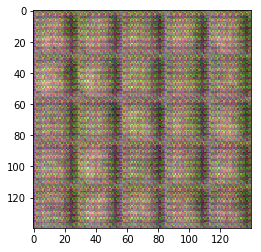

Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 1.9699
Epoch 1/1... Discriminator Loss: 0.7164... Generator Loss: 1.6796
Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 1.2303
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 1.0726
Epoch 1/1... Discriminator Loss: 0.6405... Generator Loss: 2.1231
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 0.6530... Generator Loss: 3.0348
Epoch 1/1... Discriminator Loss: 0.8156... Generator Loss: 1.1277
Epoch 1/1... Discriminator Loss: 0.7341... Generator Loss: 1.5905
Epoch 1/1... Discriminator Loss: 0.6373... Generator Loss: 1.8204


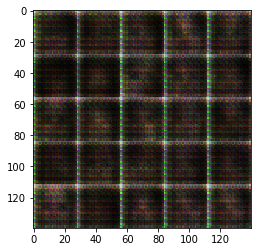

Epoch 1/1... Discriminator Loss: 0.5901... Generator Loss: 2.4031
Epoch 1/1... Discriminator Loss: 0.7855... Generator Loss: 1.2205
Epoch 1/1... Discriminator Loss: 0.6614... Generator Loss: 2.1992
Epoch 1/1... Discriminator Loss: 0.6111... Generator Loss: 1.8608
Epoch 1/1... Discriminator Loss: 0.6121... Generator Loss: 2.6164
Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 1.0758
Epoch 1/1... Discriminator Loss: 0.8545... Generator Loss: 1.1878
Epoch 1/1... Discriminator Loss: 0.7232... Generator Loss: 1.7449
Epoch 1/1... Discriminator Loss: 0.7784... Generator Loss: 1.4069
Epoch 1/1... Discriminator Loss: 0.6316... Generator Loss: 2.3109


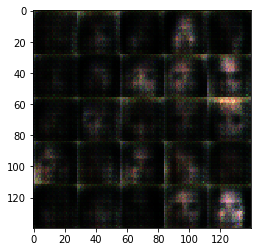

Epoch 1/1... Discriminator Loss: 0.6460... Generator Loss: 1.9982
Epoch 1/1... Discriminator Loss: 0.6557... Generator Loss: 2.0216
Epoch 1/1... Discriminator Loss: 0.7668... Generator Loss: 3.5835
Epoch 1/1... Discriminator Loss: 0.7239... Generator Loss: 1.4926
Epoch 1/1... Discriminator Loss: 0.7094... Generator Loss: 2.0975
Epoch 1/1... Discriminator Loss: 0.7432... Generator Loss: 1.3987
Epoch 1/1... Discriminator Loss: 0.7352... Generator Loss: 1.5114
Epoch 1/1... Discriminator Loss: 0.9178... Generator Loss: 1.1550
Epoch 1/1... Discriminator Loss: 0.7112... Generator Loss: 1.6129
Epoch 1/1... Discriminator Loss: 0.7208... Generator Loss: 1.7936


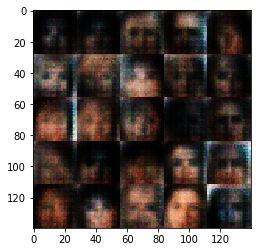

Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 3.5056
Epoch 1/1... Discriminator Loss: 0.7311... Generator Loss: 1.5073
Epoch 1/1... Discriminator Loss: 0.7564... Generator Loss: 1.4425
Epoch 1/1... Discriminator Loss: 0.8020... Generator Loss: 1.5826
Epoch 1/1... Discriminator Loss: 0.7079... Generator Loss: 1.7512
Epoch 1/1... Discriminator Loss: 0.8266... Generator Loss: 1.7678
Epoch 1/1... Discriminator Loss: 0.8556... Generator Loss: 1.9489
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 0.7457... Generator Loss: 1.3656
Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 2.3135


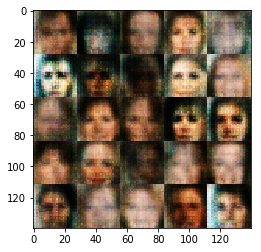

Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.5226
Epoch 1/1... Discriminator Loss: 0.8697... Generator Loss: 1.1791
Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 1.4066
Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 1.2013
Epoch 1/1... Discriminator Loss: 0.8530... Generator Loss: 1.1707
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 3.3641
Epoch 1/1... Discriminator Loss: 0.8969... Generator Loss: 1.7396
Epoch 1/1... Discriminator Loss: 0.9402... Generator Loss: 2.3467
Epoch 1/1... Discriminator Loss: 0.9106... Generator Loss: 1.9100


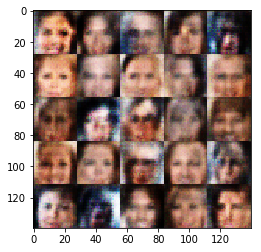

Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 2.0008
Epoch 1/1... Discriminator Loss: 0.7531... Generator Loss: 1.7401
Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 1.6148
Epoch 1/1... Discriminator Loss: 1.6431... Generator Loss: 3.4120
Epoch 1/1... Discriminator Loss: 0.8629... Generator Loss: 1.1349
Epoch 1/1... Discriminator Loss: 0.9923... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 2.1733
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 2.4933
Epoch 1/1... Discriminator Loss: 0.8782... Generator Loss: 1.3148


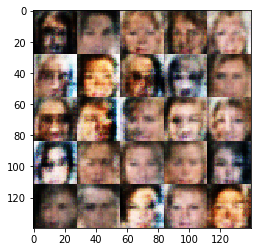

Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 2.7938
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 1.0670
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 1.5984
Epoch 1/1... Discriminator Loss: 0.8323... Generator Loss: 1.3903
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 2.4954
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 2.8091
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 0.8743


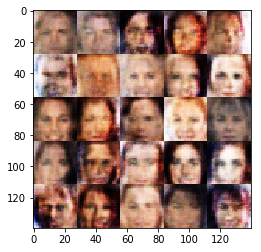

Epoch 1/1... Discriminator Loss: 0.7996... Generator Loss: 1.4043
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 1.5983
Epoch 1/1... Discriminator Loss: 0.9577... Generator Loss: 1.7555
Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 1.0375
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 1.0641
Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 1.8921
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 1.1389


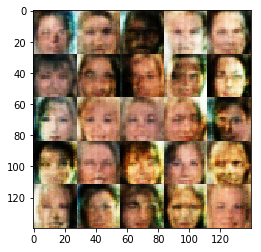

Epoch 1/1... Discriminator Loss: 0.8556... Generator Loss: 1.6686
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 0.9861
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 0.9838
Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 1.8492
Epoch 1/1... Discriminator Loss: 0.8696... Generator Loss: 1.3181
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 2.0125
Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 1.2087
Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 1.3384
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.7778


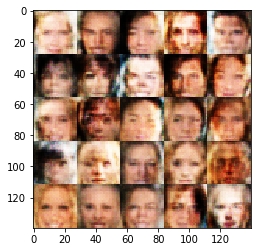

Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 1.9424
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 1.1090
Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 1.6891
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 1.8767
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 0.9335
Epoch 1/1... Discriminator Loss: 0.8482... Generator Loss: 1.6175
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.4784
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 0.7093


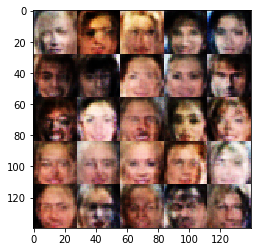

Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 1.8435
Epoch 1/1... Discriminator Loss: 0.9889... Generator Loss: 1.1896
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 1.0787
Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 1.9216
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.0035... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 1.8820
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 0.9144... Generator Loss: 1.5168


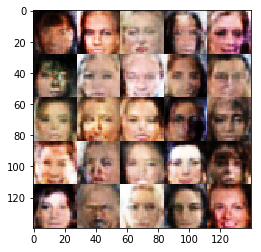

Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 1.4716
Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.0976... Generator Loss: 1.7918
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 0.8838... Generator Loss: 1.5045
Epoch 1/1... Discriminator Loss: 0.9864... Generator Loss: 1.2409


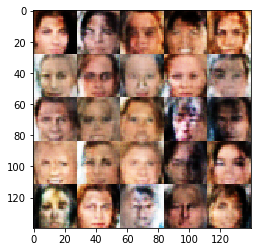

Epoch 1/1... Discriminator Loss: 0.8358... Generator Loss: 1.2489
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 1.7880
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 1.5247
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 0.9153... Generator Loss: 1.3948
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 1.6705
Epoch 1/1... Discriminator Loss: 0.9913... Generator Loss: 1.0125
Epoch 1/1... Discriminator Loss: 0.8659... Generator Loss: 1.7120
Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 1.9311


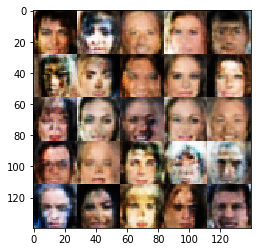

Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 0.9623... Generator Loss: 0.9866
Epoch 1/1... Discriminator Loss: 1.0007... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 1.3671
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.4968
Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 1.6033
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.7474


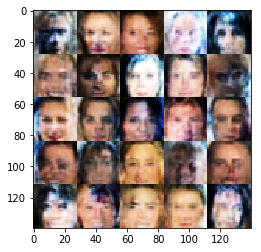

Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 1.3144
Epoch 1/1... Discriminator Loss: 0.8468... Generator Loss: 1.2185
Epoch 1/1... Discriminator Loss: 0.7908... Generator Loss: 1.2876
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 2.2119
Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 1.7229
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 1.5451
Epoch 1/1... Discriminator Loss: 0.9144... Generator Loss: 1.4418
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 2.2440
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 2.3285


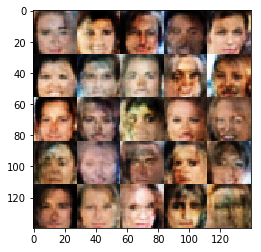

Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 1.4717
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 1.1546
Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 1.4876
Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 1.4100
Epoch 1/1... Discriminator Loss: 2.8276... Generator Loss: 3.8890
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 1.3595
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 1.6420


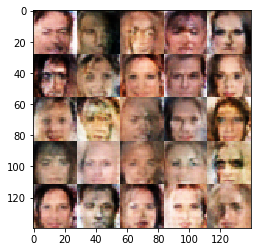

Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 0.9427
Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 1.2272
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 2.4656
Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 1.2742
Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 1.2884
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 1.8007
Epoch 1/1... Discriminator Loss: 0.9752... Generator Loss: 1.8675
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 1.0776


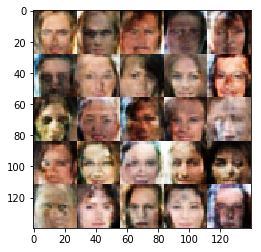

Epoch 1/1... Discriminator Loss: 0.8513... Generator Loss: 1.4639
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 1.1055
Epoch 1/1... Discriminator Loss: 0.8559... Generator Loss: 1.4570
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.5433
Epoch 1/1... Discriminator Loss: 0.9439... Generator Loss: 0.9581
Epoch 1/1... Discriminator Loss: 0.7925... Generator Loss: 1.2653
Epoch 1/1... Discriminator Loss: 2.6055... Generator Loss: 3.7328


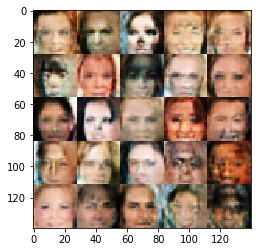

Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.0624... Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 1.3616
Epoch 1/1... Discriminator Loss: 0.9446... Generator Loss: 1.1633
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 1.6970
Epoch 1/1... Discriminator Loss: 0.6769... Generator Loss: 1.7442
Epoch 1/1... Discriminator Loss: 0.9983... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.5556


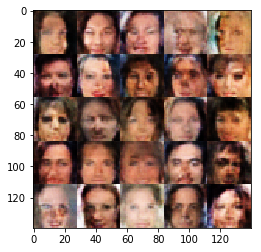

Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.5579
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.4647
Epoch 1/1... Discriminator Loss: 0.7806... Generator Loss: 1.7523
Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 1.0379
Epoch 1/1... Discriminator Loss: 0.9609... Generator Loss: 0.9731
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 1.6410
Epoch 1/1... Discriminator Loss: 0.8604... Generator Loss: 1.5208


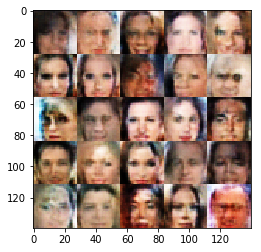

Epoch 1/1... Discriminator Loss: 0.8941... Generator Loss: 1.1468
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 1.3361
Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 0.8969... Generator Loss: 1.2401
Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 1.2458
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 1.1823
Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 1.0255
Epoch 1/1... Discriminator Loss: 0.9505... Generator Loss: 1.1658
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 0.8546... Generator Loss: 1.4749


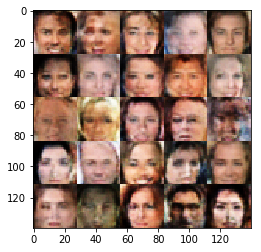

Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 1.0612
Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 1.1036
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 1.7806
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 0.8895... Generator Loss: 1.1862
Epoch 1/1... Discriminator Loss: 0.8138... Generator Loss: 3.1552
Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 2.7257


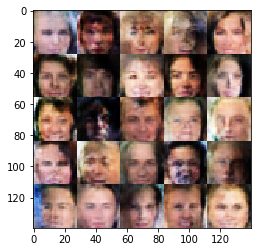

Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 0.8579... Generator Loss: 1.2301
Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 0.8874... Generator Loss: 1.3585
Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 1.2821
Epoch 1/1... Discriminator Loss: 0.8009... Generator Loss: 1.2275
Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 1.0717


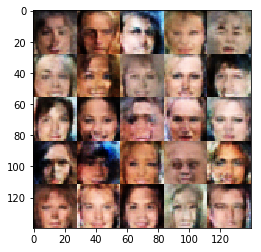

Epoch 1/1... Discriminator Loss: 0.8274... Generator Loss: 1.4603
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 0.8064... Generator Loss: 2.1815
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 1.3153
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 0.9717
Epoch 1/1... Discriminator Loss: 0.8255... Generator Loss: 1.2824
Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 0.9392
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.5118


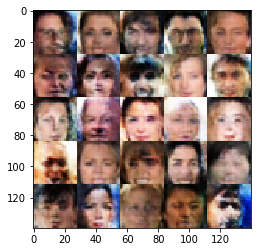

Epoch 1/1... Discriminator Loss: 0.8562... Generator Loss: 1.2819
Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 1.5972
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 1.8062
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 1.4120
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 1.2122
Epoch 1/1... Discriminator Loss: 0.9253... Generator Loss: 1.2250
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 0.9757
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.5405


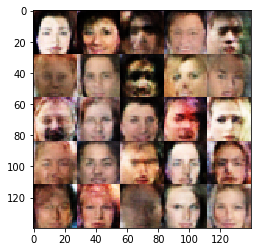

Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 0.8900... Generator Loss: 1.2423
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 1.0472
Epoch 1/1... Discriminator Loss: 0.9264... Generator Loss: 1.1890
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 2.0042
Epoch 1/1... Discriminator Loss: 0.8828... Generator Loss: 1.3027
Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 1.0773
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 1.0637
Epoch 1/1... Discriminator Loss: 0.8411... Generator Loss: 1.4493


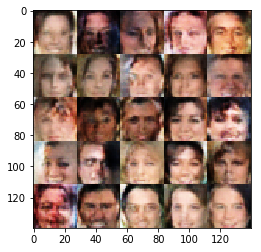

Epoch 1/1... Discriminator Loss: 0.8905... Generator Loss: 1.5562
Epoch 1/1... Discriminator Loss: 1.7384... Generator Loss: 0.3103
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 1.2997
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 1.1446
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 1.0363
Epoch 1/1... Discriminator Loss: 0.9215... Generator Loss: 1.1886
Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 1.1691
Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 0.8757... Generator Loss: 1.0966


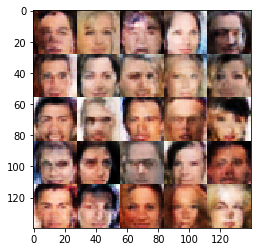

Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.4283
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 0.9515
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 0.8261... Generator Loss: 1.4675
Epoch 1/1... Discriminator Loss: 0.7450... Generator Loss: 1.7276
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 1.5144
Epoch 1/1... Discriminator Loss: 0.7861... Generator Loss: 1.5330
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 0.9102... Generator Loss: 1.3425


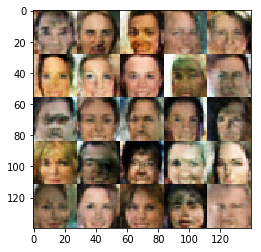

Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 0.6959... Generator Loss: 1.6750
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 3.1698
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 1.1638
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 1.5681
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.6874


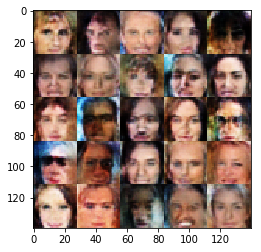

Epoch 1/1... Discriminator Loss: 0.8109... Generator Loss: 1.4755
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 1.6934
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 0.9002... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.0363... Generator Loss: 0.9756
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 1.2379
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 0.8392... Generator Loss: 1.2001
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 0.8350


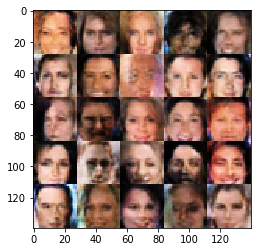

Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 1.1166
Epoch 1/1... Discriminator Loss: 0.7888... Generator Loss: 1.3281
Epoch 1/1... Discriminator Loss: 1.0733... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 1.0537
Epoch 1/1... Discriminator Loss: 0.9425... Generator Loss: 1.0780
Epoch 1/1... Discriminator Loss: 1.6368... Generator Loss: 0.3783


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.